<a href="https://colab.research.google.com/github/jparkgit/ESAA-23-2/blob/main/Week6_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[과제함](https://cafe.naver.com/esaa2019?iframe_url_utf8=%2FArticleRead.nhn%253Fclubid%3D29858915%2526page%3D1%2526menuid%3D80%2526boardtype%3DL%2526articleid%3D2413%2526referrerAllArticles%3Dfalse)

기한: 10월 13일 (금) 18시 30분

과제: 파이썬 머신러닝 완벽가이드ch4. 6\~7, 10 pg. 227\~251, 278~289 필사하여 깃허브에 업로드하고, 깃허브 링크를 댓글로 달아주세요.

#04 분류

(Week5_HW2)
1. 개요
2. Decision Tree
3. Ensemble
4. Random Forest
5. GBM (Gradient Boosting Machine)
---
(이번 숙제)
6. XGBoost (Extra Gradient Boost)
7. LightGBM\
(8, 9. 분류 실습)
10. Stacking Ensemble
11. 정리




# 4.6 XGBoost (eXtra Gradient Boost)

## 4.6.1 XGBoost 개요 및 설치

* 트리 기반 앙상블 학습
* GBM에 기반하고 있지만 GBM의 단점인 느린 수행시간 & 과적합 규제 부재 등의 문제를 해결
* 병렬 cpu 환경에서 병렬학습이 가능해 빠른 학습 가능
* Tree pruning 으로 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 줄일 수 있음
* 교차 검증 자체 내장
* 결손값 자체 처리
* C/C++로 작성되어 있어 C/C++ 핵심 라이브러리를 호출
* 독자적 XGBoost 프레임워크 기반 ("파이썬 래퍼")은 사이킷런 사용 못함
* 사이킷런과 연동할 수 있는 wrapper class를 제공: XGBClassifier, XGBRegressor

In [2]:
import xgboost as xgb
from xgboost import XGBClassifier

## 4.6.2. Python XGBoost - hyper parameter

유형
* 일반 파라미터
  * `booster`: gbtree (default) or gblinear
  * `silent`: 출력메세지 숨김
  * `nthread`: CPU 실행 thread 개수 조정
* 부스터 파라미터 (대부분)
  * `eta[defalut=0.3, alias: learning_rate]`
  * `num_boost_rounds` (same as GBM's n_estimators)
  * `min_child_weight[default=1]`: 클수록 분할을 자제, 과적합 조절용
  * `gamma[defalut=0, alias: min_split_loss]`: 최소 손실 감소 값: 해당 값보다 큰 손실이 감소된 경우 리프노드 분리 (값이 클수록 과적합 감소)
  * `max_depth[default=6]`
  * `sub_sample[default=1]`: same as GBM's subsample, 전체 데이터의 얼마만큼을 트리를 생성하는데 사용, 일반적으로 0.5~1 사이의 값
  * `colsample_bytree`
  * `lambda[defalut=1]`: L2 regulation 적용 값 (값이 클수록 과적합 감소)
  * `alpha[default=0]`: L1 regulation 적용 값 (값이 클수록 과적합 감소)
  * `scale_pos_weight[default=1]`

* 학습 태스크 파라미터
  * objective
  * `binary:logistic`: 이진 분류일 때
  * `multi:softmax`: 다중 분류일 때 (num_class 파라미터 지정 필요)
  * `multi:softprob`
  * `eval_metric`: 검증에 사용되는 함수 적용 (회귀: rmse, 분류: error)
    * rmse
    * mae
    * logloss
    * error
    * merror
    * mlogloss
    * auc





---

과적합 문제 감소 strategy
* ↓ eta & ↑ n_estimators
* ↓ max_depth
* ↑ min_child_weight
* ↑ gamma
* tweak subsample, colsample_bytree: not make the tree too complicated

## 4.6.3 Python XGBoost - 적용: Wisconsin Breast Cancer

In [3]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [4]:
dataset=load_breast_cancer()
X_features=dataset.data
y_label=dataset.target
cancer_df=pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


target
* malignant = 0
* benign = 1

In [5]:
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                                  test_size=0.2, random_state=156)

XGBoost 파이썬 단독 vs scikitrun wrapper 차이 중 하나:\
파이썬 단독: text & train dataset DMatrix 객체 별도 생성 필요

In [6]:
dtrain=xgb.DMatrix(data=X_train, label=y_train)
dtest=xgb.DMatrix(data=X_test, label=y_test)

* hyper parameter는 딕셔너리 형태로 입력
* 학습 시 XGBoost는 수행 속도를 개선하기 위해 num_boost_round 횟수 채우지 않고 조기 중단 기능을 제공
* `early_stopping_rounds`: 조기 중단할 수 있는 최소 반복 횟수
* `eval_set`: 성능 평가를 수행할 평가용 데이터세트 설정
* `eval_metric`: 성능 평가 방법
  * 분류: error, logloss

In [7]:
params={'max_depth':3,
        'eta':0.1,  # learning rate
        'objective':'binary:logistic', # 이진 분류이기 때문
        'eval_metric':'logloss',
        'early_stoppings':100
        }
num_rounds=400

In [8]:
wlist=[(dtrain, 'train'), (dtest, 'eval')]
xgb_model=xgb.train(params = params,
                    dtrain = dtrain,
                    num_boost_round = num_rounds,
                    early_stopping_rounds = 100,
                    evals = wlist)

[0]	train-logloss:0.58431	eval-logloss:0.56554
[1]	train-logloss:0.51885	eval-logloss:0.50669
[2]	train-logloss:0.46457	eval-logloss:0.45868
[3]	train-logloss:0.41713	eval-logloss:0.41822
[4]	train-logloss:0.37585	eval-logloss:0.38103
[5]	train-logloss:0.34075	eval-logloss:0.35137
[6]	train-logloss:0.31028	eval-logloss:0.32588
[7]	train-logloss:0.28283	eval-logloss:0.30127
[8]	train-logloss:0.25925	eval-logloss:0.28197
[9]	train-logloss:0.23822	eval-logloss:0.26265
[10]	train-logloss:0.21951	eval-logloss:0.24821
[11]	train-logloss:0.20251	eval-logloss:0.23231
[12]	train-logloss:0.18759	eval-logloss:0.22079
[13]	train-logloss:0.17386	eval-logloss:0.20795
[14]	train-logloss:0.16199	eval-logloss:0.19764
[15]	train-logloss:0.15109	eval-logloss:0.18950
[16]	train-logloss:0.14056	eval-logloss:0.18052
[17]	train-logloss:0.13137	eval-logloss:0.17246
[18]	train-logloss:0.12329	eval-logloss:0.16512
[19]	train-logloss:0.11565	eval-logloss:0.15828
[20]	train-logloss:0.10860	eval-logloss:0.15436
[2

In [9]:
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10], 3))


[0.904 0.004 0.908 0.267 0.992 1.    1.    0.999 0.994 0.   ]


In [10]:
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds=[1 if x>0.5 else 0 for x in pred_probs]
print(preds[:10])

[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


3장: 평가에서 생성한 `get_clf_eval()` 로 XGBoost 모델의 예측 성능 평가

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [12]:
# recall: pred_probs = xgb_model.predict(dtest)
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9951


xgboost 패키지에 내장된 시각화 기능
* `plot_importance()`: 피처의 중요도(f1기반)를 막대그래프 형식으로
* 피처 이름을 f0, f1, f2... 으로 나타냄
* 반면에 scikitrun wrapper xgboost 는 estimator 객체의 feature_importances 속성을 이용해 코드 작성 필요

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

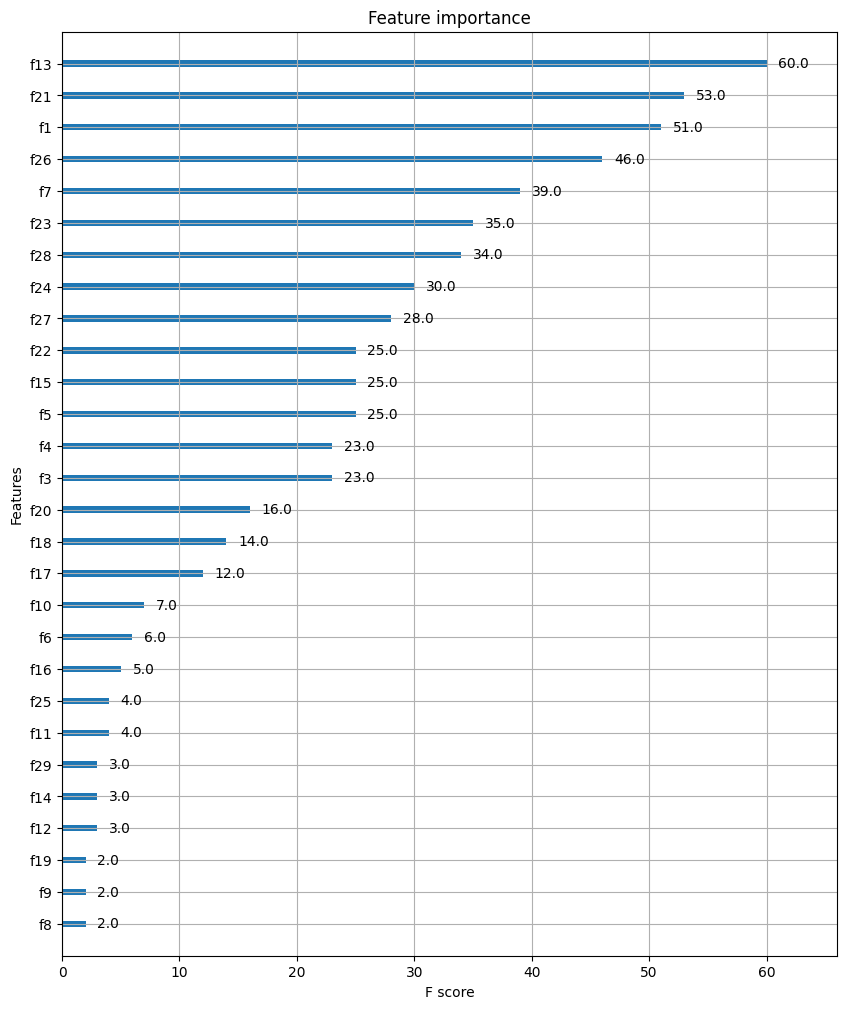

In [13]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

xgboost의 `cv()` API: 데이터 세트에 대한 교차 검증 수행 후 최적 파라미터 구하기

In [14]:
xgb.cv(params, dtrain,
      num_boost_round = 10,
      nfold = 3,
      stratified = False,
      folds = None,
      metrics = (),
      early_stopping_rounds = None)

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.584737,0.005961,0.592041,0.008024
1,0.517898,0.004745,0.532735,0.007335
2,0.462199,0.003589,0.483123,0.008418
3,0.415639,0.003043,0.441435,0.011510
4,0.375350,0.002036,0.406194,0.014400
5,0.340102,0.000854,0.373831,0.015171
6,0.308902,0.000900,0.348411,0.018183
7,0.281927,0.001335,0.324136,0.017817
8,0.257775,0.001182,0.304679,0.021239
9,0.236439,0.001313,0.286202,0.021203


## 4.6.4 Scikitrun XGBoost - 개요 및 적용

* XGBClassifier: 분류를 위한 wrapper class
* XGBRegressor: 회귀를 위한 wrapper class

In [15]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

In [16]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9947


조기 중단 parameter는 fit()에 입력
* early_stopping_rounds
* eval_metric

In [17]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals=[(X_test, y_test)]

xgb_wrapper.fit(X_train, y_train,
                early_stopping_rounds=100,
                eval_metric='logloss',
                eval_set=evals, verbose=True)

ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.56554
[1]	validation_0-logloss:0.50669
[2]	validation_0-logloss:0.45868
[3]	validation_0-logloss:0.41822
[4]	validation_0-logloss:0.38103
[5]	validation_0-logloss:0.35137
[6]	validation_0-logloss:0.32588
[7]	validation_0-logloss:0.30127
[8]	validation_0-logloss:0.28197
[9]	validation_0-logloss:0.26265
[10]	validation_0-logloss:0.24821
[11]	validation_0-logloss:0.23231
[12]	validation_0-logloss:0.22079
[13]	validation_0-logloss:0.20795
[14]	validation_0-logloss:0.19764
[15]	validation_0-logloss:0.18950
[16]	validation_0-logloss:0.18052
[17]	validation_0-logloss:0.17246
[18]	validation_0-logloss:0.16512
[19]	validation_0-logloss:0.15828
[20]	validation_0-logloss:0.15436
[21]	validation_0-logloss:0.14633
[22]	validation_0-logloss:0.13936
[23]	validation_0-logloss:0.13393
[24]	validation_0-logloss:0.13015
[25]	validation_0-logloss:0.12489
[26]	validation_0-logloss:0.12206
[27]	validation_0-logloss:0.11890
[28]	validation_0-logloss:0.11637
[29]	validation_0-loglos

n_estimators = 400 으로 설정했지만 k 후 멈춤\
k ~ k+(early_stopping_rounds=100) 까지 logloss (성능 평가 지수)가 더 이상 향상되지 않기 때문

In [18]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9951


early_stopping_rounds=10 으로 변경 후 다시 예측 성능 측정

In [19]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals=[(X_test, y_test)]

xgb_wrapper.fit(X_train, y_train,
                early_stopping_rounds=10,
                eval_metric='logloss',
                eval_set=evals, verbose=True)

ws10_preds=xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.56554
[1]	validation_0-logloss:0.50669
[2]	validation_0-logloss:0.45868
[3]	validation_0-logloss:0.41822
[4]	validation_0-logloss:0.38103
[5]	validation_0-logloss:0.35137
[6]	validation_0-logloss:0.32588
[7]	validation_0-logloss:0.30127
[8]	validation_0-logloss:0.28197
[9]	validation_0-logloss:0.26265
[10]	validation_0-logloss:0.24821
[11]	validation_0-logloss:0.23231
[12]	validation_0-logloss:0.22079
[13]	validation_0-logloss:0.20795
[14]	validation_0-logloss:0.19764
[15]	validation_0-logloss:0.18950
[16]	validation_0-logloss:0.18052
[17]	validation_0-logloss:0.17246
[18]	validation_0-logloss:0.16512
[19]	validation_0-logloss:0.15828
[20]	validation_0-logloss:0.15436
[21]	validation_0-logloss:0.14633
[22]	validation_0-logloss:0.13936
[23]	validation_0-logloss:0.13393
[24]	validation_0-logloss:0.13015
[25]	validation_0-logloss:0.12489
[26]	validation_0-logloss:0.12206
[27]	validation_0-logloss:0.11890
[28]	validation_0-logloss:0.11637
[29]	validation_0-loglos

early_stopping_rounds = 100 → 10\
              정확도: 0.9649 → 0.9561

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

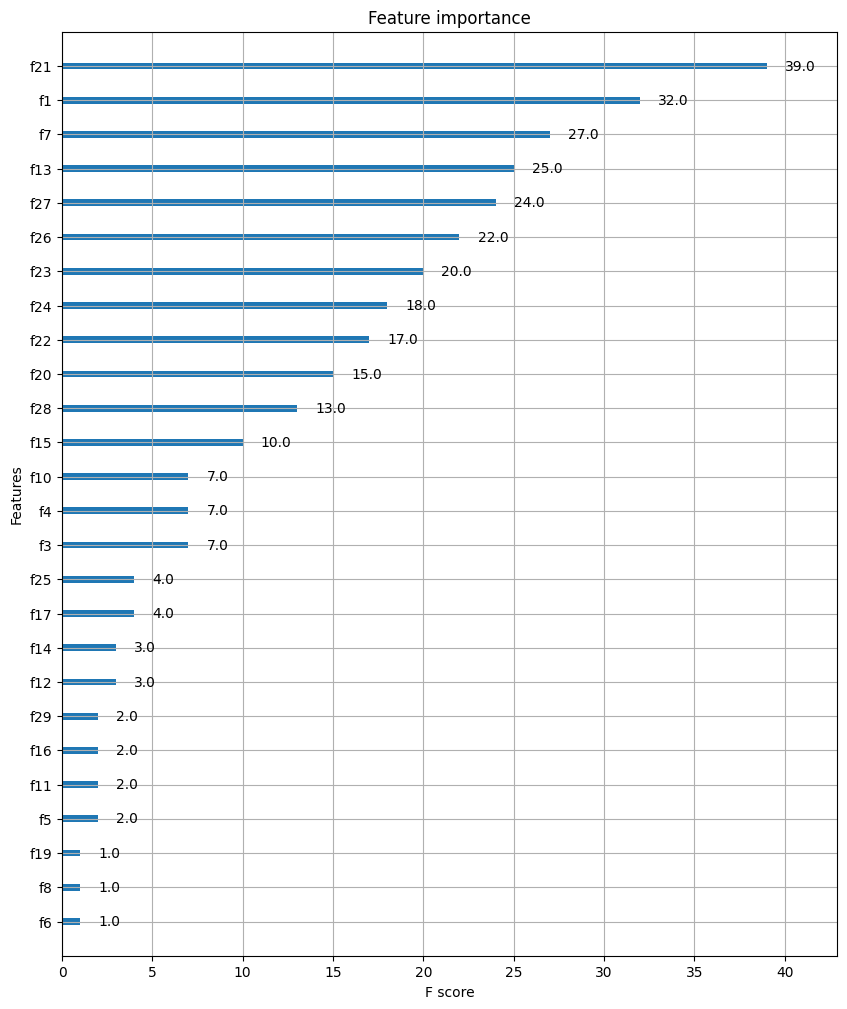

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper 클래스 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

# 4.7 LightGBM

LightGBM 의 XGBoost 대비 장점
* 더 빠른 학습과 예측 수행 시간
* 더 작은 메모리 사용량
* 카테고리형 피처의 자동 변환 & 최적 분할 (without onehotencoding)

## 4.7.1 LightGBM hyper parameter & 튜닝 방안

기본 튜닝 방안: `num_leaves` 를 중심으로\
`min_data_in leaf` (`min_child_samples`), `max_depth`를 함께 조정하며 모델의 복잡도 줄이기
* `num_leaves`: 개별 트리가 가질 수 있는 최대 리프의 개수\
높이면 정확도가 높아지지만, 트리가 깊어지고, 모델이 복잡해져, 과적합 영향도가 커짐
* `min_data_in_leaf` (`min_child_samples` in scikitrun wrapper class): 큰 값으로 설정하면 트리가 깊어지는 것을 방지
* `max_depth`: 깊이의 크기 제한
---
부스팅 계열 튜닝의 기본:
* `learning_rate`를 작게 하면서 `n_estimators`를 크게 하는 것\
(`n_estimators`를 너무 크게 하면 과적합 위험)
* 과적합 제어를 위해 regularization such as `reg_lambda`, `reg_alpha` 적용
* train dataset에 사용할 피처의 개수나 data sample record 개수를 줄이기 위해 `colsample_bytree`, `subsample` 적용

### Python LightGBM (vs) Scikitrun wrapper LightGBM (vs) Scikitrun wrapper XGBoost 파라미터 명 비교

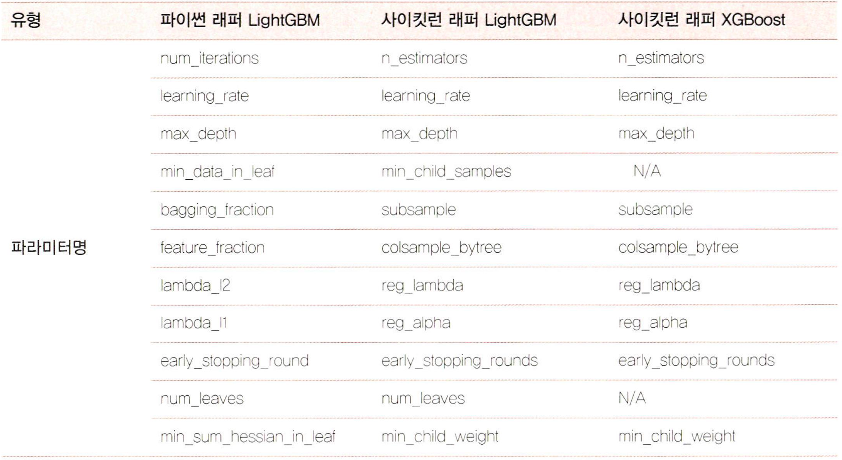

## 4.7.2 LightGBM 적용: Wisconsin Breast Cancer

Error sol

```
import lightgbm as lgb
from sklearn.datasets import make_regression

#X, y = make_regression(n_samples=1_000)

reg = lgb.LGBMRegressor/Classifier(early_stopping_rounds = 100,
                                   verbosity=1)


reg.fit(X, y)
```



In [31]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()
ftr=dataset.data
target=dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estmators는 400 설정
# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
lgbm_wrapper=LGBMClassifier(n_estimators=400,
                            early_stopping_rounds=100,
                            verbosity=1)

evals=[(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train,
                eval_metric='logloss',
                eval_set=evals)

pred=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 280, number of negative: 175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4542
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [30]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9905


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

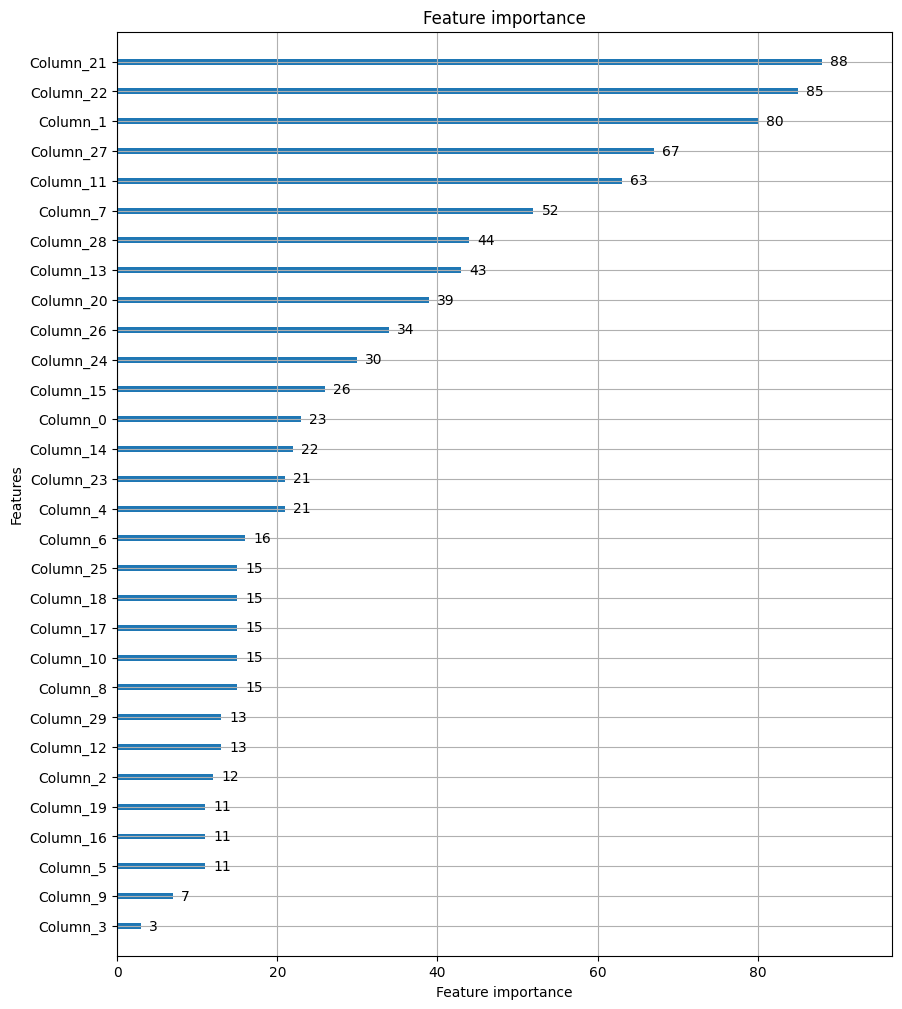

In [32]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

# 4.10 Stacking Ensemble

1. 개별 알고리즘의 예측 결과 데이터 세트를
2. 최종적인 메타 데이터 세트로 만들어
3. 별도의 ML 알고리즘으로 최종 학습 수행하고
4. 테스트 데이터를 기반으로 다시 최종 예측 수행 (메타 모델)
---
두 종류의 모델 필요
* 개별적인 기반 모델
* 최종 메타 모델 (개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습)
---
많은 개별 모델 필요 (두세개의 개별 모델만을 결합해서는 부족)


---
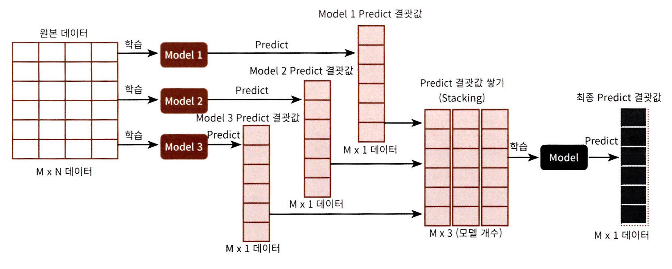

## 4.10.1 기본 stacking 모델

In [33]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()
X_data=cancer_data.data
y_label=cancer_data.target

X_train, X_test, y_train, y_test=train_test_split(X_data, y_label, test_size=0.2, random_state=0)

스태킹에 사용될 ML 알고리즘 클래스 생성

개별 모델은 KNN, random forest, decision tree, adaboost

최종 모델은 logistic regression

In [34]:
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

lr_final=LogisticRegression(C=10)

In [35]:
# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [36]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)



print('KNN 정확도:{0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도:{0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도:{0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도:0.9211
랜덤 포레스트 정확도:0.9649
결정 트리 정확도:0.9035
에이다부스트 정확도:0.9561


각 알고리즘의 예측 결과를 피처로 만들기

In [37]:
pred=np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


최종 메타 모델 (log reg) 학습하고 예측 정확도 측정

In [38]:
lr_final.fit(pred, y_test)
final=lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도:0.9649


## 4.10.2 CV set 기반의 stacking

개별 모델들이 각각 CV로
* 학습용 스태킹 데이터 생성과
* 예측을 위한 테스트용 스태킹 데이터 생성한 뒤

이를 기반으로 메타 모델이 학습 & 예측

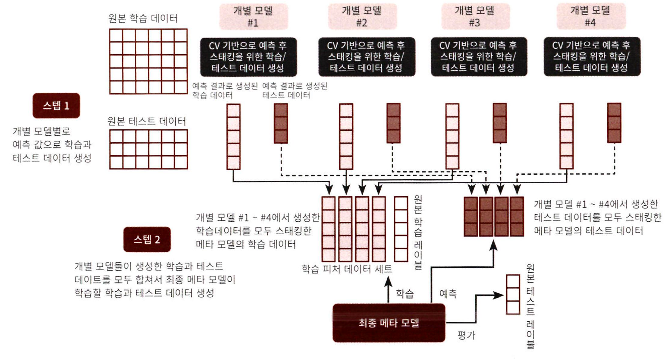

1단계

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성
    kf = KFold(n_splits = n_folds, shuffle = True, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr=X_train_n[train_index]
        y_tr=y_train_n[train_index]
        X_te=X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter]=model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean=np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [40]:
knn_train, knn_test=get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test=get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test=get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)
ada_train, ada_test=get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


2단계

In [41]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:' ,X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:' , Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:' ,Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [42]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9649
